In [1]:
import torch.nn.functional as F 
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
import random
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from einops.layers.torch import Rearrange
import math
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, Compose, ToTensor, ToPILImage

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class DSpritesDataset(Dataset):
    def __init__(self, data_path, transform=None):
        data = np.load(data_path, encoding='bytes')
        self.imgs = data['imgs']                          # shape: [N, 64, 64], values in {0,1}
        self.latents_values = data['latents_values']      # shape: [N, 6], float64
        self.latents_classes = data['latents_classes']    # shape: [N, 6], int64
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx].astype(np.float32)  # ensure float32 for tensors

        if self.transform:
            img = self.transform(img)  # use torchvision transforms
        else:
            img = torch.from_numpy(img).unsqueeze(0)  # [64,64] → [1,64,64]

        latents_values = torch.from_numpy(self.latents_values[idx]).float()
        latents_classes = torch.from_numpy(self.latents_classes[idx]).long()

        return img, latents_values, latents_classes

if __name__ == '__main__':
    data_path = "/Users/shree/OneDrive/Documents/VAE and diffusion Models/data/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"

    transform = transforms.Compose([
        transforms.ToTensor(),                   # converts to [1,64,64], float in [0,1]
     
    ])

    dSprites = DSpritesDataset(data_path, transform=transform)
    dataloader = DataLoader(dSprites, batch_size=64, shuffle=True)

    for batch_idx, (images, latents_values, latents_classes) in enumerate(dataloader):
        print(f"Batch {batch_idx}:")
        print(f"  Images shape: {images.shape}, dtype: {images.dtype}")
        print(f"  Latents values shape: {latents_values.shape}, dtype: {latents_values.dtype}")
        print(f"  Latents classes shape: {latents_classes.shape}, dtype: {latents_classes.dtype}")
        break


Batch 0:
  Images shape: torch.Size([64, 1, 64, 64]), dtype: torch.float32
  Latents values shape: torch.Size([64, 6]), dtype: torch.float32
  Latents classes shape: torch.Size([64, 6]), dtype: torch.int64


In [491]:
class VAE(nn.Module):
    def __init__(self,input_dim,input_shape,hid_dim,z_dim,model_type=None):
        super().__init__()

   
        self.mt=model_type
        self.hid2sigma=nn.Linear(hid_dim,z_dim)
        self.hid2mu=nn.Linear(hid_dim,z_dim)
        self.z2hid=nn.Linear(z_dim,hid_dim)
    

        if self.mt=='linear':
            #encoder
            self.img2hid=nn.Linear(input_dim,hid_dim)

             #decoder
            self.hid2img=nn.Linear(hid_dim,input_dim)

            self.relu=nn.ReLU()
            self.sigmoid=nn.Sigmoid()
        
        if self.mt=='conv':
            self.encoder=nn.Sequential(
                nn.Conv2d(in_channels=input_shape,out_channels=32,kernel_size=4,stride=2,padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=32,out_channels=32,kernel_size=4,stride=2,padding=1),
                nn.LayerNorm(16),
                nn.ReLU(),
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=4,stride=2,padding=1),
                nn.LayerNorm(8),
                nn.ReLU(),
                nn.Conv2d(in_channels=64,out_channels=64,kernel_size=4,stride=2,padding=1),
                nn.LayerNorm(4),
                nn.ReLU(),
                nn.Conv2d(in_channels=64,out_channels=256,kernel_size=4,stride=1,padding=0),
                
            )

            self.decoder=nn.Sequential(
                nn.ConvTranspose2d(in_channels=256,out_channels=64,kernel_size=4),
                nn.LayerNorm(4),
                nn.ReLU(),
                nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=4,stride=2,padding=1),
                nn.LayerNorm(8),
                nn.ReLU(),
                nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=4,stride=2,padding=1),
                nn.LayerNorm(16),
                nn.ReLU(),
                nn.ConvTranspose2d(in_channels=32,out_channels=32,kernel_size=4,stride=2,padding=1),
                nn.LayerNorm(32),
                nn.ReLU(),
                nn.ConvTranspose2d(in_channels=32,out_channels=input_shape,kernel_size=4,stride=2,padding=1),
                nn.Sigmoid()
            )
            
        

    

    def encode(self, x):
        h=self.relu(self.img2hid(x))
        mu=self.hid2mu(h)
        sigma=self.hid2sigma(h)

        return mu, sigma
    
    def  decode(self, z):
        h=self.relu(self.z2hid(z))
        return self.sigmoid(self.hid2img(h))
    
    def decoding(self,z):
        z=self.z2hid(z)
        z_img=z.view(z.shape[0],256,1,-1)
        x_recon=self.decoder(z_img)

        return x_recon
    
    
    
    def forward(self, x):
        if self.mt=='linear':
            mu,sigma=self.encode(x)
            eps=torch.randn_like(sigma)
            z=mu+sigma*eps
            x_recon=self.decode(z)

            
            return x_recon, mu, sigma
        
        else:
            h=self.encoder(x)
            x=h.view(-1,256*1*1)
            sigma=self.hid2sigma(x)
            mu=self.hid2mu(x)
            eps=torch.randn_like(sigma)
            z_l=mu+sigma*eps
            z=self.z2hid(z_l)
            z_img=z.view(z.shape[0],256,1,-1)
            x_recon=self.decoder(z_img)
            mu=torch.unsqueeze(mu,1)
            sigma=torch.unsqueeze(sigma,1)
            
            return x_recon,mu,sigma,z_l
    



    
    

device='cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'
# training params
epochs=10
batch_size=64
lr=5e-4
z_dim=20
input_dim=4096 #64x64
n_c=1
model_type='conv'
c=0
g=500
model=VAE(input_dim=input_dim,z_dim=z_dim,input_shape=n_c,hid_dim=256,model_type=model_type).to(device)

loss_recon=torch.nn.BCELoss(reduction='sum')

optimizer=torch.optim.Adam(model.parameters(),lr=lr)

loss_list=[]
loss_res_list=[]
loss_kl_list=[]


In [492]:
from tqdm.auto import tqdm

model.train()

for epoch in tqdm(range(epochs)):
  for batch_idx, (images, latents_values, latents_classes)  in enumerate(dataloader):

    x=images
    x=x.to(device)
    if model_type=='linear':
        x=x.to(device).view(x.shape[0],1,-1)
    optimizer.zero_grad()
    x_recon,mu,sig,_=model(x)
    loss_res=loss_recon(x_recon,x)
    loss_kl=-torch.sum(torch.log(sig**2)-(mu**2)-(sig**2)+1)/2

    loss=loss_res+16*loss_kl
    loss_list.append(loss.item())
    loss_res_list.append(loss_res.item())
    loss_kl_list.append(loss_kl.item())
    loss.backward()
    optimizer.step()

    if batch_idx == 0 :

            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss res: {loss_res:.4f}, loss kl: {loss_kl:.4f}, loss VAE:{loss:.4f}"
            )
            



            



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [0/10] Batch 0/11520                   Loss res: 257054.0000, loss kl: 2034.3204, loss VAE:289603.1250
Epoch [1/10] Batch 0/11520                   Loss res: 8621.8887, loss kl: 404.0658, loss VAE:15086.9414
Epoch [2/10] Batch 0/11520                   Loss res: 8237.9902, loss kl: 405.4174, loss VAE:14724.6699
Epoch [3/10] Batch 0/11520                   Loss res: 7991.7109, loss kl: 400.8700, loss VAE:14405.6309
Epoch [4/10] Batch 0/11520                   Loss res: 8277.1738, loss kl: 401.2158, loss VAE:14696.6260
Epoch [5/10] Batch 0/11520                   Loss res: 8257.4658, loss kl: 414.9288, loss VAE:14896.3262
Epoch [6/10] Batch 0/11520                   Loss res: 8076.7812, loss kl: 420.0463, loss VAE:14797.5215
Epoch [7/10] Batch 0/11520                   Loss res: 7877.1621, loss kl: 420.8250, loss VAE:14610.3633
Epoch [8/10] Batch 0/11520                   Loss res: 7538.7148, loss kl: 409.9866, loss VAE:14098.5010
Epoch [9/10] Batch 0/11520                   Loss r

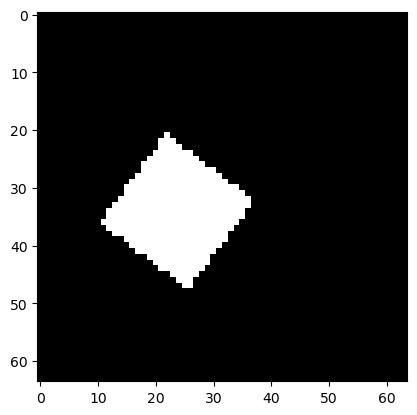

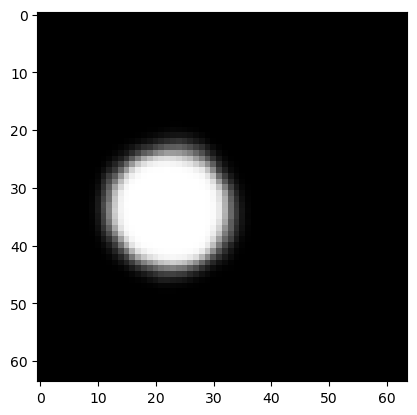

In [496]:
if model_type=='linear':
        
        import matplotlib.pyplot as plt
        for batch_idx, (images, latents_values, latents_classes) in enumerate(dataloader):
  
                img=images[0].view(1,-1).to(device)
                x_gen,mu,sig=model(img)
                x_gen=x_gen.detach()
                plt.imshow(images[0].permute(1,2,0).numpy(),cmap='gray')
                plt.show()
                plt.imshow(x_gen.view(1,64,-1).permute(1,2,0).cpu(),cmap='gray')
                plt.show()
                print(x_gen)
                break

else:
        for batch_idx, (images, latents_values, latents_classes) in enumerate(dataloader):
  
                plt.imshow(images[0].permute(1,2,0).numpy(),cmap='gray')
                plt.show()
                img=images[0].to(device)
                x_gen,mu,sig,_=model(img.unsqueeze(0))
                x_gen=x_gen.detach()
                plt.imshow(x_gen.squeeze(0).cpu().permute(1,2,0),cmap='gray')
                plt.show()
                break

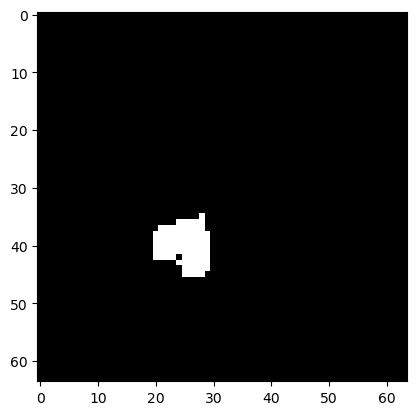

tensor([[-0.6301, -0.7979, -0.3760, -1.6545,  0.1013, -0.2774, -0.7365,  0.3529,
          0.6707,  1.5974,  0.1245, -0.5700, -1.0571,  0.3292, -0.4957, -1.0714,
         -0.4473, -0.4791, -0.1301,  0.5043]], device='cuda:0',
       grad_fn=<AddBackward0>)


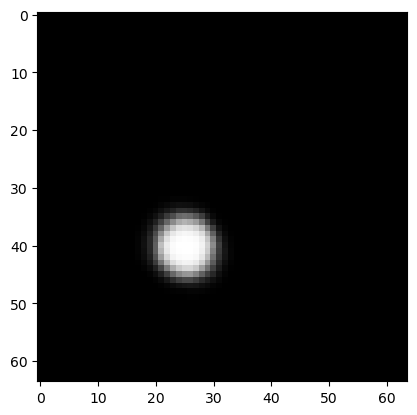

In [502]:
for batch_idx, (images, latents_values, latents_classes) in enumerate(dataloader):
  
                plt.imshow(images[0].permute(1,2,0).numpy(),cmap='gray')
                plt.show()
                img=images[0].to(device)
                x_gen,mu,sig,z=model(img.unsqueeze(0))
                print(z)
                x_gen=x_gen.detach()
                plt.imshow(x_gen.squeeze(0).cpu().permute(1,2,0),cmap='gray')
                plt.show()
                break
                
                

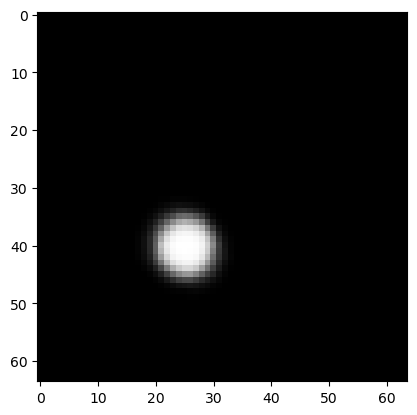

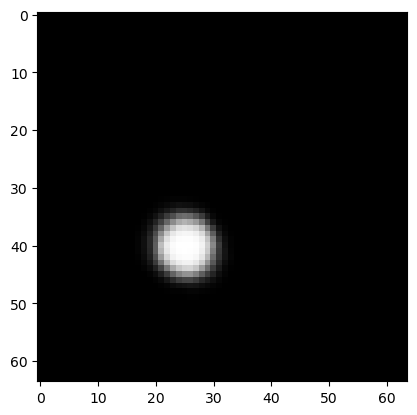

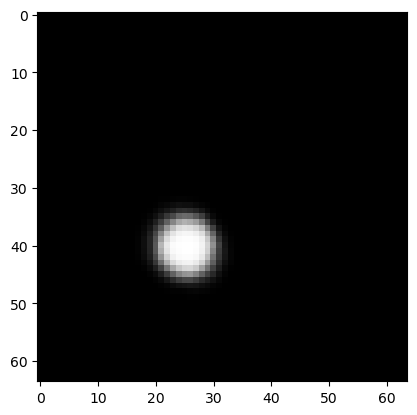

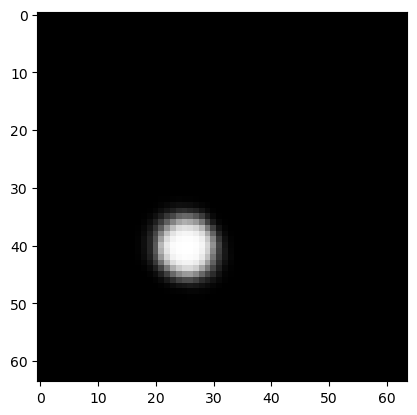

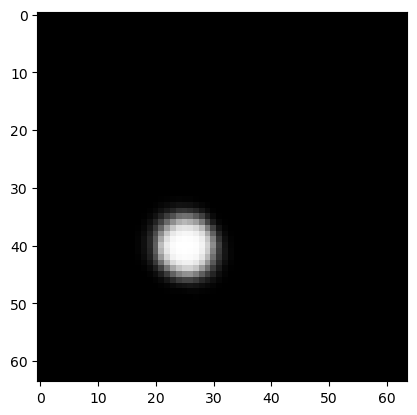

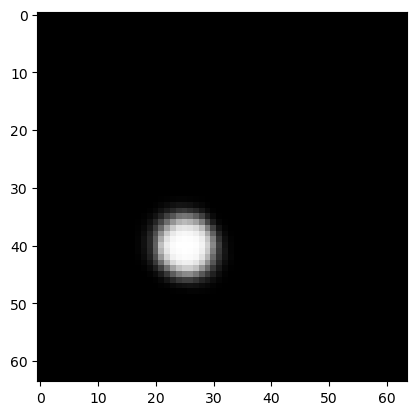

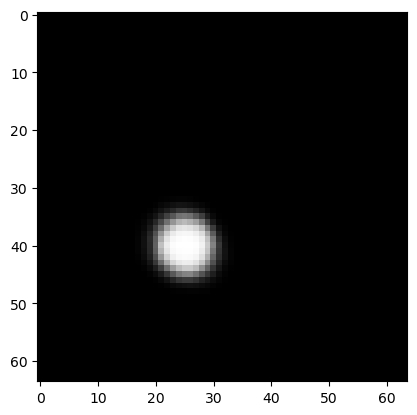

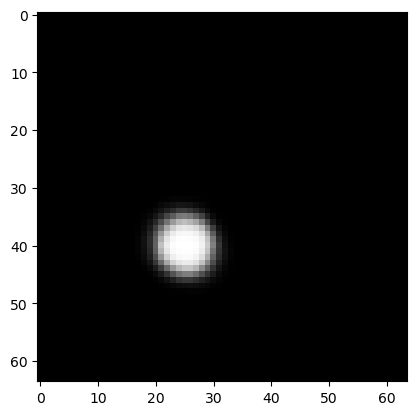

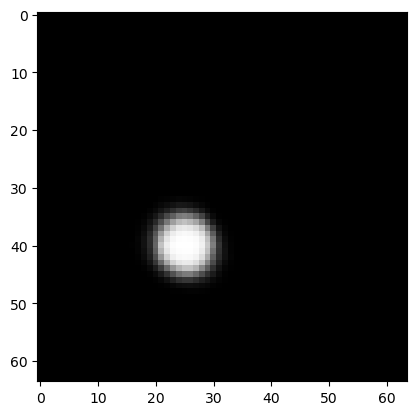

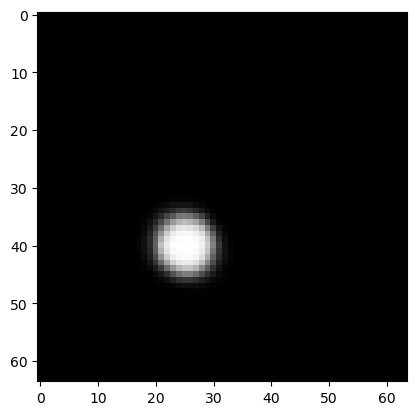

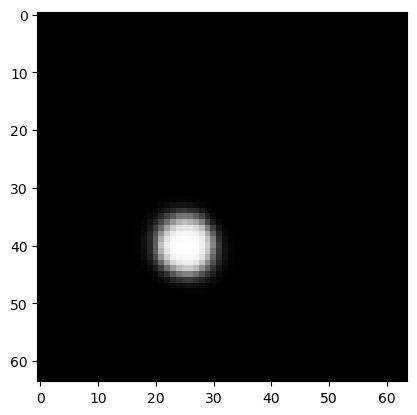

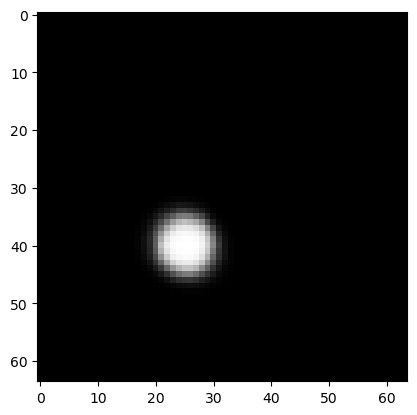

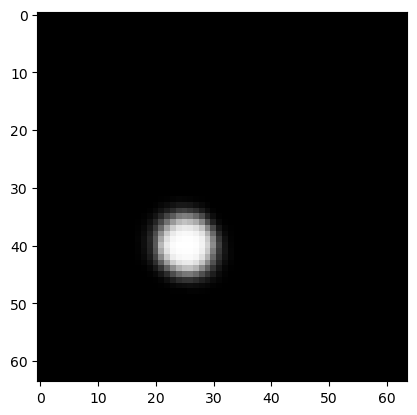

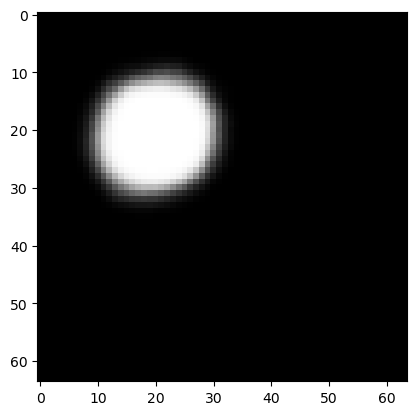

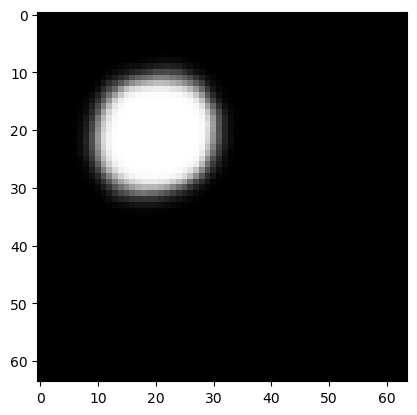

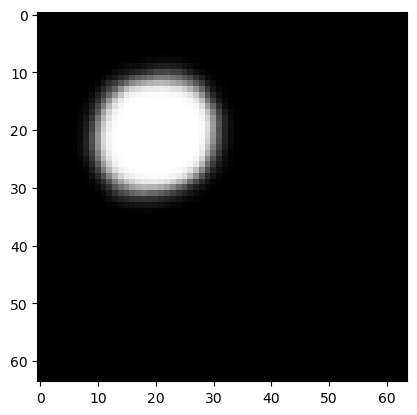

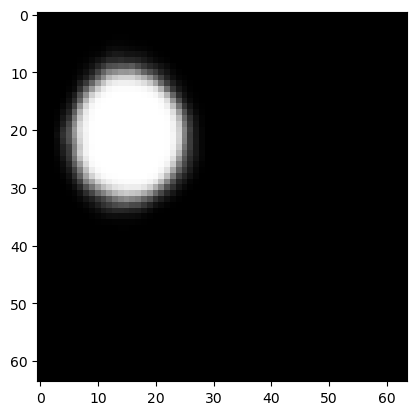

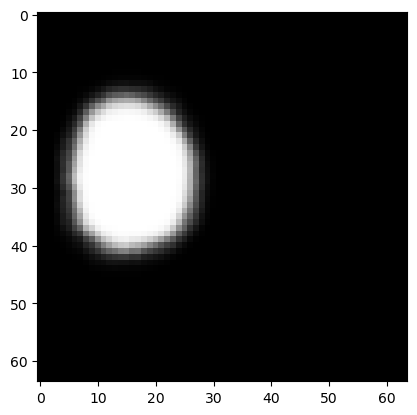

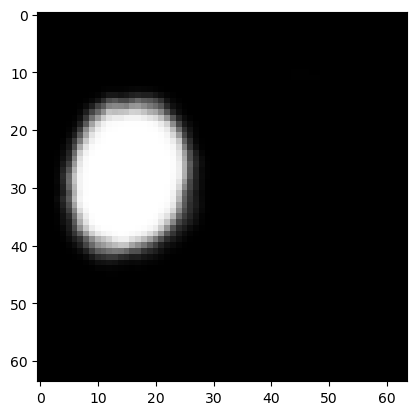

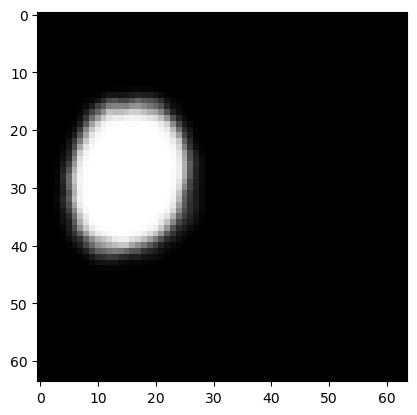

In [503]:
z_l=z.clone()
for i in range(20):
    z_l[0][i]-=3
    x_recon=model.decoding(z_l)
    x_gen=x_recon.detach()
    plt.imshow(x_gen.squeeze(0).cpu().permute(1,2,0),cmap='gray')
    plt.show()

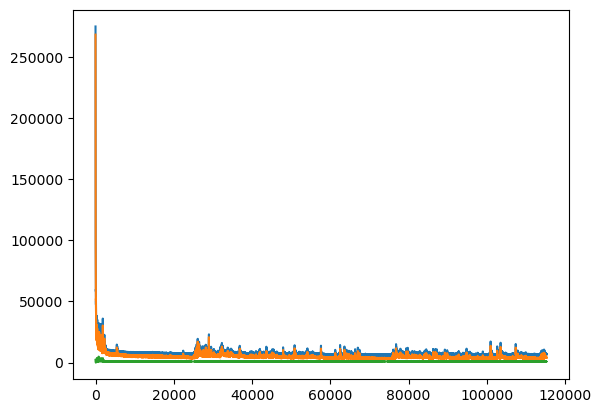

In [463]:
plt.plot(loss_list)
plt.plot(loss_res_list)
plt.plot(loss_kl_list)
